In [1]:
# imoprt libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob # allows us to list all files to a directory
import IPython
import IPython.display as ipd # to play the Audio Files

import librosa # main package for working with Audio Data
import librosa.display

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , confusion_matrix , ConfusionMatrixDisplay , classification_report

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import socket



In [2]:
# Make a list of all the wav files in the dataset and store them in a variable
audio_files = glob("C:/Users/Rohan Mahesh Rao/Documents/PES1UG20EC156/Sem 6/ML/project/gtzan/Data/genres_original/*/*.wav")
audio_files = [path.replace('//', '/') for path in audio_files]
print(type(audio_files))

<class 'list'>


In [3]:
# load the audio file and show raw data and sample rate
y, sr = librosa.load(audio_files[0])
print("Y is a numpy array:", y)
print("Shape of Y:", y.shape)
print("Sample Rate:", sr)

Y is a numpy array: [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]
Shape of Y: (661794,)
Sample Rate: 22050


In [4]:
def visualise_song(filename):
    
    y, sr = librosa.load(filename, sr=None)

    # turn raw data array to pd series and plot the audio example
    pd.Series(y).plot(figsize=(8,2), title="Raw Audio Example", color='green');

    # Use STFT on raw audio data
    D = librosa.stft(y)
    # convert from aplitude to decibel values by taking the absolute value of D in reference what the max value would be
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    # see the shape of transformed data
    print("New shape of transformed data", S_db.shape)
    
    # plot transformed data as spectogram
    fig, ax = plt.subplots(figsize=(3,3))
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
    ax.set_title('Spectogram Example', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f');

def get_mfcc(y,sr):

    # Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc_mean_vars = []
 
    for i in range (20):

        mfcc_mean_vars.append(np.mean(mfcc[i]))
        mfcc_mean_vars.append(np.var(mfcc[i]))

    mfcc_mean_vars = np.array(mfcc_mean_vars)

    mfcc_mean_vars = mfcc_mean_vars.tolist()

    return mfcc_mean_vars

In [5]:
#### The audio feature extraction fucntion ##########

## inputs must be of type string

import librosa
import numpy as np

def extract_features(filename):

    y, sr = librosa.load(filename, sr=None)

    visualise_song(filename)

    mfcc_values = get_mfcc(y,sr) #1d

    # Spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

    c_mean = np.mean(np.mean(spectral_centroid))
    b_mean = np.mean(np.mean(spectral_bandwidth))
    r_mean = np.mean(np.mean(spectral_rolloff))
    
    # Chroma features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = np.mean(np.mean(chroma_stft))
    chroma_stft_var = np.var(np.var(chroma_stft))
    
    # Root-mean-square (RMS) energy
    rmse = librosa.feature.rms(y=y)
    rms_mean = np.mean(np.mean(rmse))
    rms_var = np.var(np.var(rmse))
    
    # Zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(np.mean(zcr))
    zcr_var = np.var(np.var(zcr))
    
    # Harmony features
    harmonic_percussive = librosa.effects.hpss(y)
    harmony = librosa.feature.tonnetz(y=harmonic_percussive[0], sr=sr)
    harmony_mean = np.mean(np.mean(harmony))
    harmony_var = np.var(np.var(harmony))
    
    # Perceived loudness
    perceived_loudness = librosa.feature.spectral_flatness(y=y)
    perceived_loudness_mean = np.mean(np.mean(perceived_loudness))
    perceived_loudness_var = np.var(np.var(perceived_loudness))
    
    # Tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr) # 0d 
    
    features = []
    features.append([chroma_stft_mean,
                                rms_mean,
                                c_mean,
                                b_mean,
                                r_mean,
                                zcr_mean,
                                harmony_mean,
                                perceived_loudness_mean,tempo])

    features_ls = features[0]

    features_ls.extend(mfcc_values)
   
 
    return features_ls


In [6]:
# load csv file
df = pd.read_csv("C:/Users/Rohan Mahesh Rao/Documents/PES1UG20EC156/Sem 6/ML/project/gtzan/Data/features_30_sec.csv")

In [7]:
df.head() # first 5 entries

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,classical.00000.wav,661794,0.252392,0.084153,0.036245,0.000221,1505.166424,44457.89174,1559.005740,43682.97327,...,86.137909,-0.320783,100.827087,1.772985,95.440735,0.889234,97.133331,-0.842025,120.865791,classical
1,classical.00001.wav,661794,0.214995,0.085010,0.030625,0.000161,1360.643672,61611.21285,1441.243134,32378.72969,...,158.498138,-4.289846,75.676430,0.591009,134.617706,2.877631,153.630554,0.373281,123.707390,classical
2,classical.00002.wav,661794,0.277958,0.083759,0.043860,0.000193,1490.275364,38993.33753,1600.115744,31200.89904,...,85.150917,-1.309433,77.170746,2.945177,74.202652,-1.655027,59.096081,-2.896193,53.000435,classical
3,classical.00003.wav,661794,0.234229,0.083451,0.029442,0.000357,1526.629882,91344.30989,1499.439342,60196.22756,...,125.197098,0.597389,111.539612,-0.595684,151.719910,2.341259,133.902283,2.640536,210.365616,classical
4,classical.00004.wav,661794,0.221574,0.085000,0.042316,0.000209,1705.563259,68132.45346,1646.064010,25963.45828,...,83.138351,-4.125299,69.470551,-4.787771,131.776337,-4.774069,115.447807,-4.603727,217.122009,classical


In [8]:
df.shape # see the shape of df
# df.info() # infos about the samples, features and datatypes
#df.isnull().sum() # checking for missing values

(299, 60)

In [9]:
# drop filename column and show new df first 5 entries
df = df.drop(labels=['length','filename','chroma_stft_var','rms_var','spectral_centroid_var','spectral_bandwidth_var','rolloff_var','zero_crossing_rate_var','harmony_var','perceptr_var'],axis=1)
df.head()

,chroma_stft_mean,rms_mean,spectral_centroid_mean,spectral_bandwidth_mean,rolloff_mean,zero_crossing_rate_mean,harmony_mean,perceptr_mean,tempo,mfcc1_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.252392,0.036245,1505.166424,1559.005740,2716.306158,0.098223,-0.000047,-0.000121,95.703125,-268.195526,...,86.137909,-0.320783,100.827087,1.772985,95.440735,0.889234,97.133331,-0.842025,120.865791,classical
1,0.214995,0.030625,1360.643672,1441.243134,2387.729130,0.087766,-0.000051,-0.000090,112.347147,-324.061157,...,158.498138,-4.289846,75.676430,0.591009,134.617706,2.877631,153.630554,0.373281,123.707390,classical
2,0.277958,0.043860,1490.275364,1600.115744,2785.294011,0.090046,-0.000020,-0.000129,99.384014,-235.253723,...,85.150917,-1.309433,77.170746,2.945177,74.202652,-1.655027,59.096081,-2.896193,53.000435,classical
3,0.234229,0.029442,1526.629882,1499.439342,2916.000387,0.108946,-0.000035,-0.000118,71.777344,-326.861084,...,125.197098,0.597389,111.539612,-0.595684,151.719910,2.341259,133.902283,2.640536,210.365616,classical
4,0.221574,0.042316,1705.563259,1646.064010,3174.931743,0.112857,-0.000059,-0.000102,161.499023,-259.915131,...,83.138351,-4.125299,69.470551,-4.787771,131.776337,-4.774069,115.447807,-4.603727,217.122009,classical


In [10]:
# import labelencoder and scaler
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.preprocessing import StandardScaler
encoder = LabelEncoder()
scaler = StandardScaler()

data = df.iloc[:, :-1] # obtain metadata
labels = df.iloc[:, -1] # get labels column
labels.to_frame() # change datatype to pandas dataframe

print(labels)

0      classical
1      classical
2      classical
3      classical
4      classical
         ...    
294        metal
295        metal
296        metal
297        metal
298        metal
Name: label, Length: 299, dtype: object


In [11]:
# assign x and y, scale x and encode y
x = np.array(data, dtype = float)
x = scaler.fit_transform(data)

#### IMPORTANT #####

print (type(x))

########### the music features must also be of the type numpy.ndarray #################
y = encoder.fit_transform(labels)

print(y)

x.shape, y.shape

<class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]


((299, 49), (299,))

In [12]:
# split data to train and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## verify the type of x_train and x_test
print(type(x_train),type(x_test))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


((239, 49), (60, 49), (239,), (60,))

In [13]:
def cross_val(classifier_rf, K, metadata, label, title, return_clf = False):
    # scores is used to give average of accuracy
    scores = []
    cv = KFold(n_splits=K)
    
    # K fold analysis, used for spliting the data into k batches
    for train_index, test_index in cv.split(metadata):
      
        X_train, y_train = metadata[train_index], label[train_index]
        X_test, y_test = metadata[test_index], label[test_index]

        classifier_rf.fit(X_train, y_train)
        scores.append(classifier_rf.score(X_test, y_test))
    
    # Display the average score
    print(title + " Cross-Validation Accuracy Score: ", round(np.mean(scores), 2))
    
    # returns the classifier if needed
    if(return_clf == True):
        return classifier_rf

def display_confusionMatrix(classifier_rf, X, y, title):
  cm = confusion_matrix(y, classifier_rf.predict(X), labels=classifier_rf.classes_)
  normed_c = (cm.T / cm.astype(np.float).sum(axis=1)).T
  disp = ConfusionMatrixDisplay(confusion_matrix=normed_c,
                                display_labels=classifier_rf.classes_)
  disp.plot(
      cmap=plt.cm.Blues
      )
  disp.ax_.set_title(title + " Confusion Matrix:")

(239, 49)
(60, 49)
Model Accuracy :  0.95
Cross Val Cross-Validation Accuracy Score:  0.77
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      0.83      0.91        18
           2       0.87      1.00      0.93        20

    accuracy                           0.95        60
   macro avg       0.96      0.94      0.95        60
weighted avg       0.96      0.95      0.95        60



C:\Users\Rohan Mahesh Rao\AppData\Local\Temp\ipykernel_2960\752599356.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normed_c = (cm.T / cm.astype(np.float).sum(axis=1)).T


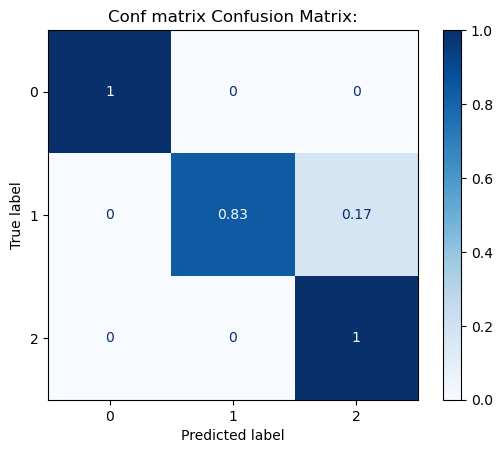

In [14]:
XGB=XGBClassifier()
XGB.fit(x_train,y_train)
print(x_train.shape)
print(x_test.shape)
y_pred = XGB.predict(x_test)

print("Model Accuracy : ",accuracy_score(y_test,y_pred))

cross_val(XGB, 5, x_test, y_test, title="Cross Val", return_clf = False)

print(classification_report(y_test, XGB.predict(x_test)))

display_confusionMatrix(XGB, x_test, y_test, title = "Conf matrix")

In [15]:
testpath = "C:/Users/Rohan Mahesh Rao/Documents/PES1UG20EC156/Sem 6/ML/project/gtzan/Data/genres_original/metal/metal.00070.wav"
# Play the first Audio file
ipd.Audio(testpath)

Classical = 0       Jazz = 1        Metal = 2       

In [16]:
# original_labels = encoder.inverse_transform(y)
# print(original_labels)

In [17]:
s = socket.socket()

s.bind(('0.0.0.0', 8061))
s.listen(0)

New shape of transformed data (1025, 1293)
['metal', '172.0']


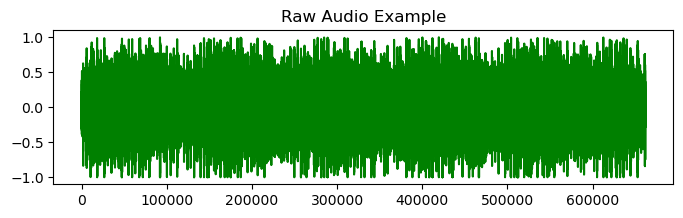

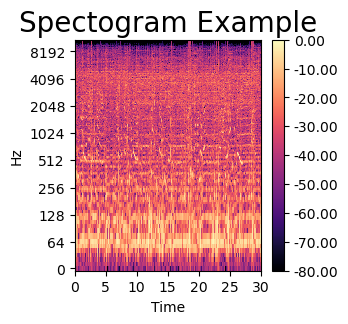

In [18]:
vals = extract_features(testpath)

extracted_tempo = np.around(vals[8])

label_ls = ["classical", "jazz", "metal"]

pred = XGB.predict([vals])

final_data = [str(label_ls[pred[0]]),str(extracted_tempo)]
print(final_data)

In [19]:
while True:
    client, addr = s.accept()
    print(f"Connection from {addr[0]}:{addr[1]}")
    client.send(','.join(final_data).encode())  # Convert list of strings to a single string and encode to bytes
    client.close()

Connection from 192.168.223.68:64402
Connection from 192.168.223.68:64403
Connection from 192.168.223.68:64404
Connection from 192.168.223.68:64405
Connection from 192.168.223.68:64406
Connection from 192.168.223.68:64407
Connection from 192.168.223.68:49402
Connection from 192.168.223.68:49403
Connection from 192.168.223.68:49404
Connection from 192.168.223.68:49405
Connection from 192.168.223.68:49406
Connection from 192.168.223.68:49407
Connection from 192.168.223.68:49408
Connection from 192.168.223.68:49409
Connection from 192.168.223.68:49410
Connection from 192.168.223.68:49411
Connection from 192.168.223.68:49412
Connection from 192.168.223.68:49413
Connection from 192.168.223.68:49414
Connection from 192.168.223.68:49415
Connection from 192.168.223.68:49416
Connection from 192.168.223.68:64772
Connection from 192.168.223.68:64773
Connection from 192.168.223.68:64774
Connection from 192.168.223.68:64775
Connection from 192.168.223.68:64776
Connection from 192.168.223.68:64777
C